In [28]:
# @software{brevitas,
#   author       = {Alessandro Pappalardo},
#   title        = {Xilinx/brevitas},
#   year         = {2021},
#   publisher    = {Zenodo},
#   doi          = {10.5281/zenodo.3333552},
#   url          = {https://doi.org/10.5281/zenodo.3333552}
# }

!pip install brevitas netron onnx onnxoptimizer

In [29]:
import torch
print(torch.__version__)
! python --version

1.10.0+cu111
Python 3.7.13


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant
import netron
import time
from IPython.display import IFrame
from brevitas.quant import Int8Bias as BiasQuant
import brevitas.quant_tensor

In [31]:
# Hyperparameters 

epochs = 20
batch_size = 64
valid_size = 0.2 
learning_rate = 0.00005 # optimizer parameter
momentum = 0.9 # optimizer parameter 
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False # turned off the nondeterministic algo used in cuDNN
# For repeatable experiments, set random seeds for anything using random number generation (numpy and random)
torch.manual_seed(random_seed) 

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# convert data to torch.FloatTensor
transform = transforms.ToTensor() 
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [32]:
# Set up Dataloaders

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

(20, 1, 28, 28)


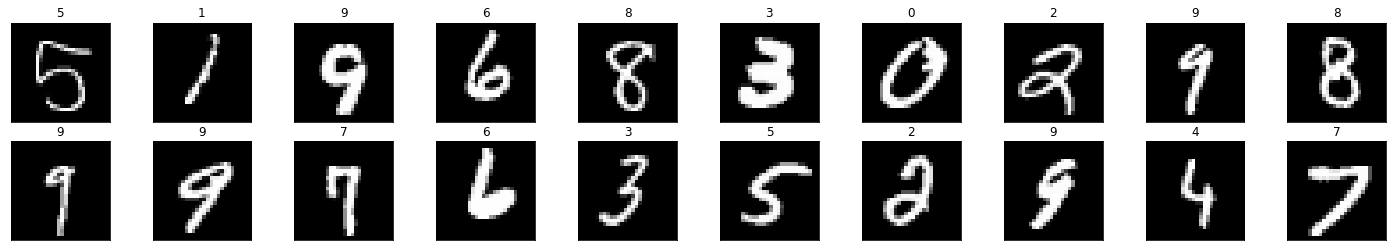

In [33]:
# Show example images 

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

<class 'numpy.float32'>


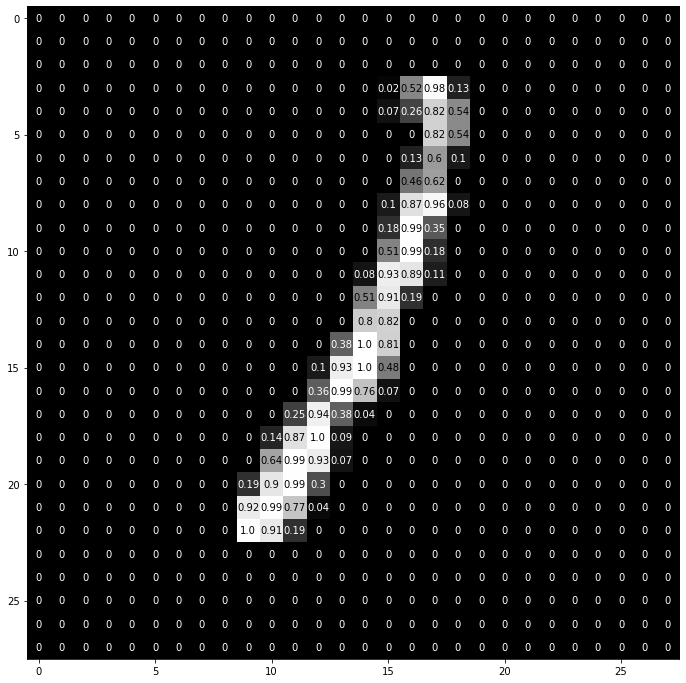

In [34]:
# Show an image in detail 

img = np.squeeze(images[1])
print(type(img[0][0])) # float32: sign bit, 8 bits exponent, 23 bits mantissa
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [35]:
# Define integer-only MLP architecture using Brevitas 

class Net_default(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.quant_inp = qnn.QuantIdentity(
            bit_width=4, return_quant_tensor=True)
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = qnn.QuantLinear(28*28, 512, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)      
        # qnn.relu is stateful (need to declare separate relu functions for the layers)
        self.relu1 = qnn.QuantReLU(
             bit_width=4, return_quant_tensor=True)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = qnn.QuantLinear(512, 512, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(
             bit_width=4, return_quant_tensor=True)
        # linear layer (n_hidden -> 10)
        self.fc3 = qnn.QuantLinear(512, 10, bias=True, weight_bit_width=3, bias_quant=BiasQuant, return_quant_tensor=True)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)         # no dropout in the eval() mode (no impact in hw)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # quantize the input 
        x = self.quant_inp(x)
        # add hidden layer, with relu activation function
        x = self.relu1(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = self.relu2(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x

In [36]:
# Define integer-only MLP architecture using Brevitas 

class Net_20(nn.Module):
    def __init__(self):
        super(Net_20,self).__init__()
        self.quant_inp = qnn.QuantIdentity(
            bit_width=20, return_quant_tensor=True)
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = qnn.QuantLinear(28*28, 512, bias=True, weight_bit_width=20, bias_bit_width=20, return_quant_tensor=True)      
        # qnn.relu is stateful (need to declare separate relu functions for the layers)
        self.relu1 = qnn.QuantReLU(
             bit_width=20, return_quant_tensor=True)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = qnn.QuantLinear(512, 512, bias=True, weight_bit_width=20, bias_bit_width=20, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(
             bit_width=20, return_quant_tensor=True)
        # linear layer (n_hidden -> 10)
        self.fc3 = qnn.QuantLinear(512, 10, bias=True, weight_bit_width=20, bias_bit_width=20, return_quant_tensor=True)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)         # no dropout in the eval() mode (no impact in hw)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # quantize the input 
        x = self.quant_inp(x)
        # add hidden layer, with relu activation function
        x = self.relu1(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = self.relu2(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x
        
# initialize the NN
model = Net_20()
print(model)

Net_20(
  (quant_inp): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restr

In [37]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [38]:
# number of epochs to train the model
n_epochs = 15
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.960669 	Validation Loss: 0.000493
Validation loss decreased (inf --> 0.000493).  Saving model ...
Epoch: 2 	Training Loss: 0.350875 	Validation Loss: 0.000543
Epoch: 3 	Training Loss: 0.277985 	Validation Loss: 0.000644
Epoch: 4 	Training Loss: 0.230024 	Validation Loss: 0.000393
Validation loss decreased (0.000493 --> 0.000393).  Saving model ...
Epoch: 5 	Training Loss: 0.193611 	Validation Loss: 0.000430
Epoch: 6 	Training Loss: 0.166627 	Validation Loss: 0.000046
Validation loss decreased (0.000393 --> 0.000046).  Saving model ...
Epoch: 7 	Training Loss: 0.147269 	Validation Loss: 0.000246
Epoch: 8 	Training Loss: 0.132055 	Validation Loss: 0.000103
Epoch: 9 	Training Loss: 0.117885 	Validation Loss: 0.000013
Validation loss decreased (0.000046 --> 0.000013).  Saving model ...
Epoch: 10 	Training Loss: 0.108369 	Validation Loss: 0.000297
Epoch: 11 	Training Loss: 0.098470 	Validation Loss: 0.000062
Epoch: 12 	Training Loss: 0.090821 	Validation Loss: 0.0

In [39]:
# Test loss and accuracy

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.076952

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 98% (1122/1135)
Test Accuracy of     2: 97% (1008/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (953/982)
Test Accuracy of     5: 96% (858/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 96% (994/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 97% (979/1009)

Test Accuracy (Overall): 97% (9756/10000)


In [40]:
# Save weights as csv 

import pandas as pd 

! mkdir save_parameters
! cd save_parameters
fc1_weights_tmp = model.fc1.weight.detach().numpy().reshape(-1)
fc1_weights = model.fc1.weight.detach().numpy().reshape(1, -1)
print(fc1_weights_tmp)
print(fc1_weights)
pd.DataFrame(fc1_weights).to_csv('fc1_weights.dat', index=False, header=False)
fc1_bias = model.fc1.bias.detach().numpy().reshape(1, -1)
pd.DataFrame(fc1_bias).to_csv('fc1_bias.dat', index=False, header=False)

fc2_weights = model.fc2.weight.detach().numpy().reshape(1, -1)
pd.DataFrame(fc2_weights).to_csv('fc2_weights.dat', index=False, header=False)
fc2_bias = model.fc2.bias.detach().numpy().reshape(1, -1)
pd.DataFrame(fc2_bias).to_csv('fc2_bias.dat', index=False, header=False)

fc3_weights = model.fc3.weight.detach().numpy().reshape(1, -1)
pd.DataFrame(fc3_weights).to_csv('fc3_weights.dat', index=False, header=False)
fc3_bias = model.fc3.bias.detach().numpy().reshape(1, -1)
pd.DataFrame(fc3_bias).to_csv('fc3_bias.dat', index=False, header=False)


from google.colab import files

files.download('fc1_weights.dat')
files.download('fc1_bias.dat')

files.download('fc2_weights.dat')
files.download('fc2_bias.dat')

files.download('fc3_weights.dat')
files.download('fc3_bias.dat')

[-0.01254923 -0.01846748 -0.00285797 ...  0.00098357  0.03090337
 -0.01098317]
[[-0.01254923 -0.01846748 -0.00285797 ...  0.00098357  0.03090337
  -0.01098317]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>